In [ ]:
#autoload modules in notebook
%load_ext autoreload
%autoreload 2  

In [ ]:
from itertools import combinations
import json
import pandas as pd
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
import wandb
from transformers import DistilBertTokenizer, TFDistilBertModel
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import cv2
import CLIP_model
import CLIP_data_load
import utils

In [ ]:
# Hyperparameters
train_percentage = 0.8
test_percentage = 0.2
validation_percentage = 0.15
latent_dim_imgs = 1024
latent_dim_text = 768
latent_dim_common = 512
batch_size = 8
SEED = 116
img_shape = (128,128,3)
text_input_shape = (200)
bert_model_name = 'distilbert-base-uncased' #bert-base-multilingual-uncased
max_len = 200
model_name = 'clip_duplicated_text'

# Paths
all_images_path = 'dataset/resized_train/'
project_location = '/home/ale/Documents/University_arc/University/MSc/Transformers/project'
all_captions_path = f'{project_location}/dataset/caption_prediction_train.csv'  
all_concept_ids_path = f'{project_location}/dataset/concept_detection_train.csv'
all_concepts_path = f'{project_location}/dataset/concepts.csv'

zip_dataset_location = f'{project_location}/dataset/resized_train.zip'
dataset_extract_location = "/"
model_loc = f'{project_location}/weights/{model_name}.h5'

In [ ]:
#Merging all dataframes toghether into ID, caption, cuis, concepts
captionsDF = pd.read_csv(all_captions_path, sep='\t')
concept_id_df = pd.read_csv(all_concept_ids_path, sep='\t')
concept_df = pd.read_csv(all_concepts_path, sep=',')

concepts = concept_df.set_index('concept').T.to_dict('list')
concept_id_df.cuis = concept_id_df.cuis.apply(lambda x: x.split(';'))
concept_id_df['concepts'] = concept_id_df.cuis.apply(lambda cuis: {concepts[cui][0] for cui in cuis})

captionsDF = pd.merge(captionsDF,concept_id_df, on="ID")
captionsDF.ID = captionsDF.ID.apply(lambda x: x+'.jpg')

In [1]:
tokenizer = DistilBertTokenizer.from_pretrained(bert_model_name)
elems = CLIP_data_load.paths_captions_emb_list(captionsDF,  all_images_path,tokenizer=tokenizer,max_len=max_len)

NameError: name 'DistilBertTokenizer' is not defined

In [ ]:
print(len(elems))

83275


In [ ]:
sums = []

In [ ]:
for idx, elem in enumerate(elems):
    p = elems[idx]['path']
    image = cv2.imread(p, 0)
    s = image.sum()
    elems[idx]['sum'] = s
    sums.append(s)

In [2]:
elems.sort(key=lambda x: x['sum'])

NameError: name 'elems' is not defined

In [10]:
elems[0]

{'path': 'dataset/resized_train/ImageCLEFmedCaption_2022_train_000649.jpg',
 'caption': 'complete exclusion of popliteal aneurysm follow endovascular stenting',
 'encoding': {'input_ids': [101,
   3143,
   15945,
   1997,
   3769,
   22779,
   2389,
   2019,
   11236,
   7274,
   2213,
   3582,
   2203,
   7103,
   28817,
   8017,
   26261,
   24360,
   102,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   

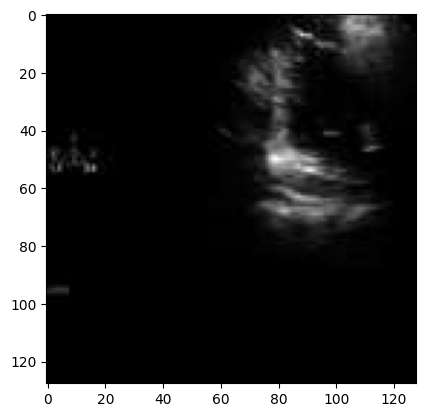

In [11]:
import matplotlib.pyplot as plt
idx = 250
image = cv2.imread(elems[idx]['path'], 0)
plt.imshow(image, cmap='gray')
plt.show()

In [12]:
captionsDF['concepts']

0        {angiogram, Cardiac Tamponade, Pericardial sac...
1        {Aortic arch structure, Aberrant, Structure of...
2        {Contrast Media, catheter device, Cardiac shun...
3        {Pseudoaneurysm, tooth filling, angiogram, Emb...
4           {Left popliteal artery, Peripheral, angiogram}
                               ...                        
83270    {Round Nodule, Small, Diameter (qualifier valu...
83271                          {X-Ray Computed Tomography}
83272    {catheter device, Implants, Plain x-ray, Struc...
83273        {Magnetic Resonance Imaging, Pituitary Gland}
83274    {Plain x-ray, Chest, Decreased translucency, H...
Name: concepts, Length: 83275, dtype: object

In [13]:
print(elems[idx]['caption'])

apical fourchamber view seem to show the two separate subvalvular structure of the doubleorifice mitral valve


In [14]:
filtered = captionsDF[captionsDF['concepts'].apply(lambda x: "Magnetic Resonance Imaging" in x)]
filtered = filtered[filtered['concepts'].apply(lambda x: "Peripheral" in x)]

In [15]:
filtered

,ID,caption,cuis,concepts
32146,ImageCLEFmedCaption_2022_train_032362.jpg,the postcontrast axial image show the large le...,"[C0024485, C0205131, C0221198, C1518897, C0205...","{Peripheral, Axial, Lesion, Magnetic Resonance..."
32351,ImageCLEFmedCaption_2022_train_032567.jpg,axial enhance image with fat suppression at e...,"[C0024485, C0205131, C0728721, C0205100, C0027...","{Central, Peripheral, Neoplasms, Psychological..."
32400,ImageCLEFmedCaption_2022_train_032616.jpg,axial repetition time echo time image show ...,"[C0024485, C0205131, C1510412, C0205100, C0522...","{With intensity, Volar, Peripheral, Hand, Pseu..."
33784,ImageCLEFmedCaption_2022_train_034004.jpg,axial magnetic resonance image after gadoliniu...,"[C0024485, C0205131, C0016911, C0577559, C0205...","{Septal, gadolinium, Peripheral, Axial, Mass o..."
33848,ImageCLEFmedCaption_2022_train_034068.jpg,post contrast fs with predominant peripheral ...,"[C0024485, C0205100]","{Magnetic Resonance Imaging, Peripheral}"
...,...,...,...,...
74997,ImageCLEFmedCaption_2022_train_075430.jpg,female with a large abdominal mass diagnose wi...,"[C0024485, C0000734, C0855055, C2825493, C0000...","{Central, Abdomen, With intensity, Abdominal m..."
75079,ImageCLEFmedCaption_2022_train_075512.jpg,mri brain show a welldefine lobulated intraaxi...,"[C0024485, C0006104, C4763780, C0228194, C0221...","{Left lateral ventricle structure, Brain, Peri..."
75101,ImageCLEFmedCaption_2022_train_075534.jpg,contrast magnetic resonance imaging of brain s...,"[C0024485, C0180108, C0006104, C0205100, C0221...","{Compressed structure, Brain, Peripheral, Lesi..."
80325,ImageCLEFmedCaption_2022_train_080779.jpg,transverse section at level show prolongatio...,"[C0024485, C0446380, C3715208, C0007776, C0205...","{AV Block First Degree by ECG Finding, Transve..."


In [16]:
filtered[0:1].ID.values[0]

'ImageCLEFmedCaption_2022_train_032362.jpg'

In [17]:
start = 21

In [18]:
filtered['concepts'].values[start]

{'Adjacent',
 'Bone structure of humerus',
 'Heterogeneity',
 'Left upper arm structure',
 'Magnetic Resonance Imaging',
 'Peripheral',
 'Surrounding (qualifier value)'}

In [19]:
captionsDF[captionsDF['caption'].apply(lambda x: len(x.split(' '))==1)]

,ID,caption,cuis,concepts
434,ImageCLEFmedCaption_2022_train_000436.jpg,nephrostogram,[C0002978],{angiogram}
583,ImageCLEFmedCaption_2022_train_000585.jpg,wallstent,[C0002978],{angiogram}
1127,ImageCLEFmedCaption_2022_train_001131.jpg,pseudoaneurysm,"[C0002978, C1510412]","{angiogram, Pseudoaneurysm}"
1377,ImageCLEFmedCaption_2022_train_001384.jpg,cannulation,"[C0002978, C0917707]","{angiogram, Cannulation}"
2345,ImageCLEFmedCaption_2022_train_002356.jpg,pseudoaneurysm,"[C0002978, C1510412]","{angiogram, Pseudoaneurysm}"
...,...,...,...,...
81823,ImageCLEFmedCaption_2022_train_082552.jpg,preoperative,"[C1306645, C0037303]","{Plain x-ray, Bone structure of cranium}"
82168,ImageCLEFmedCaption_2022_train_082952.jpg,abdomenbersicht,"[C1306645, C0817096]","{Plain x-ray, Chest}"
82749,ImageCLEFmedCaption_2022_train_083635.jpg,preoperative,"[C1306645, C0037303]","{Plain x-ray, Bone structure of cranium}"
82762,ImageCLEFmedCaption_2022_train_083651.jpg,orthopantomogram,"[C1306645, C0037303]","{Plain x-ray, Bone structure of cranium}"


In [20]:
captions = captionsDF['caption'].values

In [21]:
captionsDF.sort_values('caption', ascending=True,key=lambda x: x.str.len())

,ID,caption,cuis,concepts
57202,ImageCLEFmedCaption_2022_train_057537.jpg,ct,[C0040405],{X-Ray Computed Tomography}
60914,ImageCLEFmedCaption_2022_train_061276.jpg,ct,[C0040405],{X-Ray Computed Tomography}
52312,ImageCLEFmedCaption_2022_train_052621.jpg,ct,[C0040405],{X-Ray Computed Tomography}
50452,ImageCLEFmedCaption_2022_train_050750.jpg,mri,[C0040405],{X-Ray Computed Tomography}
18829,ImageCLEFmedCaption_2022_train_018950.jpg,pan,"[C1306645, C0037303]","{Plain x-ray, Bone structure of cranium}"
...,...,...,...,...
21814,ImageCLEFmedCaption_2022_train_021956.jpg,landmark for cephalometric analysis s sella c...,"[C1306645, C0037303, C3178884, C0036609, C0205...","{Chin, Sagittal, Pogonion, Central, Inferior, ..."
63950,ImageCLEFmedCaption_2022_train_064343.jpg,a old woman of indian descent live in denmark...,"[C0032743, C0205386, C0019664, C0015967, C0231...","{Enlarged, Foot, Head, Left breast, Elbow, Pos..."
43520,ImageCLEFmedCaption_2022_train_043786.jpg,fdgpetct after chemotherapy reveal a high upta...,"[C3641247, C0013216, C0046056, C0183512, C0700...","{Difficult (qualifier value), Treated with, FD..."
64036,ImageCLEFmedCaption_2022_train_064429.jpg,additional diagnostic workup draw a day prior ...,"[C0032743, C0046056, C1446409, C0205160, C0019...","{Titer, Clinical, Positive, Positron-Emission ..."


In [22]:
filtered['concepts'].values[start]

{'Adjacent',
 'Bone structure of humerus',
 'Heterogeneity',
 'Left upper arm structure',
 'Magnetic Resonance Imaging',
 'Peripheral',
 'Surrounding (qualifier value)'}

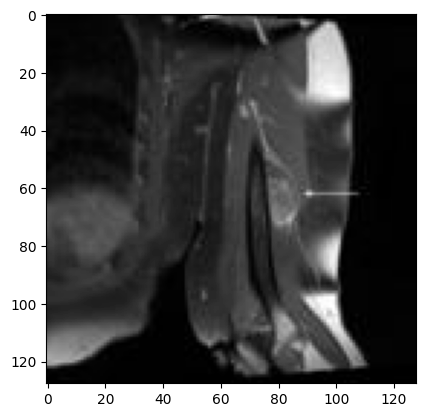

In [23]:
p = "dataset/resized_train/" + filtered['ID'].values[start]

ima = cv2.imread(p, 0)

plt.imshow(ima, cmap="gray")
plt.show()

In [36]:
captionsDF

,ID,caption,cuis,concepts
0,ImageCLEFmedCaption_2022_train_000001.jpg,pericardial tamponade with clear distinction o...,"[C0002978, C0007177, C0031050]","{angiogram, Cardiac Tamponade, Pericardial sac..."
1,ImageCLEFmedCaption_2022_train_000002.jpg,angiography of the aortic arch show delay visu...,"[C0002978, C0003489, C0175631, C0443127, C0226...","{Aortic arch structure, Aberrant, Structure of..."
2,ImageCLEFmedCaption_2022_train_000003.jpg,balloonocclude retrograde transvenous oblitera...,"[C0002978, C0021102, C0085590, C0232180, C0205...","{Contrast Media, catheter device, Cardiac shun..."
3,ImageCLEFmedCaption_2022_train_000004.jpg,film after glue embolization show no filling i...,"[C0002978, C0013931, C0178866, C1510412]","{Pseudoaneurysm, tooth filling, angiogram, Emb..."
4,ImageCLEFmedCaption_2022_train_000005.jpg,peripheral in posteroanterior projection angio...,"[C0002978, C0205100, C0226463]","{Left popliteal artery, Peripheral, angiogram}"
...,...,...,...,...
83270,ImageCLEFmedCaption_2022_train_084253.jpg,high resolution ct five month after the onset ...,"[C0040405, C1514893, C4281590, C0700321, C1704...","{Round Nodule, Small, Diameter (qualifier valu..."
83271,ImageCLEFmedCaption_2022_train_084254.jpg,computed tomography chest axial view,[C0040405],{X-Ray Computed Tomography}
83272,ImageCLEFmedCaption_2022_train_084255.jpg,patient post placement of equistream hemodialy...,"[C1306645, C0817096, C0021102, C0085590, C0038...","{catheter device, Implants, Plain x-ray, Struc..."
83273,ImageCLEFmedCaption_2022_train_084256.jpg,mri of the pituitary be normal mrimagnetic res...,"[C0024485, C0032005]","{Magnetic Resonance Imaging, Pituitary Gland}"


In [44]:
concepts_to_exclude = [
'X-Ray Computed Tomography',
'Plain x-ray',
'Magnetic Resonance Imaging',
'Ultrasonography']

In [61]:
captionsDF_reduced = captionsDF[captionsDF['concepts'].apply(lambda x: len(x) == 1)]

In [62]:
captionsDF_reduced

,ID,caption,cuis,concepts
8,ImageCLEFmedCaption_2022_train_000010.jpg,no right coronary ostium be observe use aortog...,[C0002978],{angiogram}
22,ImageCLEFmedCaption_2022_train_000024.jpg,when corsair microcatheter reach ostium of rca...,[C0002978],{angiogram}
73,ImageCLEFmedCaption_2022_train_000075.jpg,the patients leave coronary angiography,[C0002978],{angiogram}
120,ImageCLEFmedCaption_2022_train_000122.jpg,area to be crop,[C0002978],{angiogram}
123,ImageCLEFmedCaption_2022_train_000125.jpg,patient twentyfouryearold male after bike acc...,[C0002978],{angiogram}
...,...,...,...,...
83232,ImageCLEFmedCaption_2022_train_084213.jpg,weighted axial mri,[C0024485],{Magnetic Resonance Imaging}
83237,ImageCLEFmedCaption_2022_train_084218.jpg,leave ventriculogram show incomplete presenta...,[C0002978],{angiogram}
83263,ImageCLEFmedCaption_2022_train_084246.jpg,chocardiographic image show aortic vgtation,[C0041618],{Ultrasonography}
83268,ImageCLEFmedCaption_2022_train_084251.jpg,abdominal compute tomography show a left iliac...,[C0040405],{X-Ray Computed Tomography}


In [54]:
concepts,df =  utils.common_concepts_covering_all_dataset(captionsDF,10000000, concepts_to_exclude)
concepts = [concept for concept in concepts if concept[2] != 0]
len(concepts)

3125

In [55]:
def get_count(elems):
    s = 0
    for elem in elems:
        s+=elem[2]

    return s

In [58]:
a = list(reversed(concepts))
get_count(a)

79946

In [60]:
list(reversed(a))

[('Chest', 7720, 7720),
 ('angiogram', 6027, 6019),
 ('Abdomen', 5772, 5641),
 ('Bone structure of cranium', 5144, 5101),
 ('Lesion', 3845, 3028),
 ('Axial', 3187, 2599),
 ('Pelvis', 3176, 2335),
 ('Lower Extremity', 2739, 2552),
 ('Bilateral', 2722, 1390),
 ('Mass of body structure', 2341, 1637),
 ('Sagittal', 2012, 1615),
 ('Left', 1696, 738),
 ('Right', 1531, 512),
 ('Implants', 1427, 559),
 ('Contrast Media', 1406, 566),
 ('Measured', 1337, 740),
 ('Upper Extremity', 1335, 1213),
 ('Physiologic calcification', 1327, 568),
 ('Vertebral column', 1315, 1016),
 ('Neoplasms', 1289, 785),
 ('Dorsal', 1255, 535),
 ('Liver', 1229, 582),
 ('Anterior', 1186, 435),
 ('Brain', 1147, 631),
 ('soft tissue', 1129, 385),
 ('Proximal', 1085, 300),
 ('Operative Surgical Procedures', 1010, 372),
 ('Pleural effusion disorder', 984, 277),
 ('Diameter (qualifier value)', 979, 379),
 ('Increased', 966, 415),
 ('Heterogeneity', 958, 352),
 ('Adjacent', 956, 361),
 ('Lung', 954, 345),
 ('Left ventricular s

In [49]:
get_count(a[:3000])

14397

In [40]:
get_count(a)

83275

In [41]:
captionsDF[captionsDF['concepts'].apply(lambda x: "X-Ray Computed Tomography" in x)]

[autoreload of CLIP_data_load failed: Traceback (most recent call last):
  File "/home/ale/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/ale/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/ale/miniconda3/envs/tf/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/ale/Documents/University_arc/University/MSc/Transformers/project/CLIP_dat

,ID,caption,cuis,concepts
43469,ImageCLEFmedCaption_2022_train_043734.jpg,positron emission tomography and compute tomog...,"[C0032743, C0040405, C1699633, C0024204, C0243...","{Enlarged, Supraclavicular approach, lymph nod..."
43471,ImageCLEFmedCaption_2022_train_043736.jpg,positive signal in the medial tibiofemoral com...,"[C0040399, C0040405, C0439858, C0448196]","{Structure of medial condyle of femur, X-Ray C..."
43474,ImageCLEFmedCaption_2022_train_043739.jpg,a coronal view of the pet ct scan without defi...,"[C0032743, C0040405, C0046056, C2986972, C0221...","{fluorodeoxyglucose F18, Positron-Emission Tom..."
43480,ImageCLEFmedCaption_2022_train_043746.jpg,pet scan show the hypermetabolic lesion in the...,"[C0032743, C0034606, C0342952, C0221198, C0226...","{Radionuclide Imaging, Left pulmonary artery, ..."
43488,ImageCLEFmedCaption_2022_train_043754.jpg,pet ct image of patient,"[C0032743, C0040405]","{Positron-Emission Tomography, X-Ray Computed ..."
...,...,...,...,...
83266,ImageCLEFmedCaption_2022_train_084249.jpg,coronal computed tomography view demonstrate f...,"[C0040405, C0016658, C0226153]","{X-Ray Computed Tomography, Structure of infra..."
83268,ImageCLEFmedCaption_2022_train_084251.jpg,abdominal compute tomography show a left iliac...,[C0040405],{X-Ray Computed Tomography}
83269,ImageCLEFmedCaption_2022_train_084252.jpg,noncontrast ct ap large bladder stone with se...,"[C0040405, C0549177, C0005682, C0006736, C0205...","{Calculi, X-Ray Computed Tomography, Urinary B..."
83270,ImageCLEFmedCaption_2022_train_084253.jpg,high resolution ct five month after the onset ...,"[C0040405, C1514893, C4281590, C0700321, C1704...","{Round Nodule, Small, Diameter (qualifier valu..."


In [42]:
utils.print_metric(captionsDF,200)

(395458,) ['angiogram' 'Cardiac Tamponade' 'Pericardial sac structure' ... 'Chest'
 'Decreased translucency' 'Homogeneity']
total test samples: 83275
total concepts with duplicates: 395458
unique concepts: 8374
max concepts per sample: 111
min concepts per sample: 2
avg concepts per sample: 16.005704777751365

concepts of sample 0: {'angiogram', 'Cardiac Tamponade', 'Pericardial sac structure'}
concepts of sample 1: {'Aortic arch structure', 'Aberrant', 'Structure of right subclavian artery', 'angiogram', 'Imagery'}
concepts of sample 2: {'Contrast Media', 'catheter device', 'Cardiac shunt', 'Sclerosing agent', 'Balloon Dilatation', 'Balloon dilatation catheter', 'Implants', 'Balloon Occlusion', 'Optimum', 'angiogram', 'Economic Inflation', 'Complete', 'Stasis'}
concepts of sample 3: {'Pseudoaneurysm', 'tooth filling', 'angiogram', 'Embolization, Therapeutic'}
concepts of sample 4: {'Left popliteal artery', 'Peripheral', 'angiogram'}

most common concepts: 
[('X-Ray Computed Tomography